In [82]:
#!pip install tensorflow
#!pip install -q pyyaml h5py
#!pip install tf-nightly

In [34]:
#!pip install -q tensorflow-hub

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image
import os

import matplotlib.pylab as plt

PATH = "D:/Users/rdemaio/Desktop/immagini"

- checkpoint_folder = folder to save the model
- PATH = folder to retrieve images for trainig

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [9]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [10]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [12]:

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'test')

train_good_dir = os.path.join(train_dir, 'Good')
train_bad_dir = os.path.join(train_dir, 'Bad')
validation_good_dir = os.path.join(validation_dir, 'Good')
validation_bad_dir = os.path.join(validation_dir, 'Bad')

num_good_tr = len(os.listdir(train_good_dir))
num_bad_tr = len(os.listdir(train_bad_dir))

num_good_val = len(os.listdir(validation_good_dir))
num_bad_val = len(os.listdir(validation_bad_dir))

total_train = num_good_tr + num_bad_tr
total_val = num_good_val + num_bad_val
print('total training good images:', num_good_tr,"(",100*num_good_tr/total_train,"%)" )
print('total training bad images:', num_bad_tr,"(",100*num_bad_tr/total_train,"%)")
print('total validation good images:', num_good_val,"(",100*num_good_val/total_val,"%)")
print('total validation bad images:', num_bad_val,"(",100*num_bad_val/total_val,"%)")
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training good images: 96 ( 41.02564102564103 %)
total training bad images: 138 ( 58.97435897435897 %)
total validation good images: 12 ( 35.294117647058826 %)
total validation bad images: 22 ( 64.70588235294117 %)
--
Total training images: 234
Total validation images: 34


In [13]:
# Controlliamo se ci sono duplicati nelle cartelle ed in caso andremo a rimuoverli manualmente
x = [f for f in os.listdir(train_good_dir)]+[f for f in os.listdir(train_bad_dir)]+[f for f in os.listdir(validation_good_dir)]+ [f for f in os.listdir(validation_bad_dir)]
from collections import Counter
c= Counter(x)
for key,value in c.items():
    if value > 1:
        print("File ",key)
        print("It is in:")
        if key in [f for f in os.listdir(train_good_dir)]:
            print(os.path.join(train_good_dir, key))
        if key in [f for f in os.listdir(train_bad_dir)]:
            print(os.path.join(train_bad_dir, key))
        if key in [f for f in os.listdir(validation_good_dir)]:
            print(os.path.join(validation_good_dir, key))
        if key in [f for f in os.listdir(validation_bad_dir)]:
            print(os.path.join(validation_bad_dir, key))

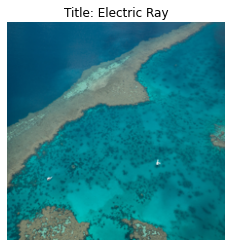

In [14]:
from random import choice
file  = choice([f for f in os.listdir(train_good_dir)])
im = Image.open(os.path.join(train_good_dir, file)).resize(IMAGE_SHAPE)
#im
im = np.array(im)/255.0
#im.shape
result = classifier.predict(im[np.newaxis, ...])
#result.shape
predicted_class = np.argmax(result[0], axis=-1)
#predicted_class
plt.imshow(im)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Title: " + predicted_class_name.title())

In [15]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0, 
    horizontal_flip=True,
    rotation_range=0,
    width_shift_range = .0,
    height_shift_range = .0,
    shear_range = 0.0,
    zoom_range = 0.1,
    fill_mode = "nearest"
)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0, 
    horizontal_flip=True,
    rotation_range=0,
    width_shift_range = .0,
    height_shift_range = .0,
    shear_range = 0.0,
    zoom_range = 0.1,
    fill_mode = "nearest"
)

In [16]:
batch_size = 15
epochs = 7

In [17]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size, 
                                                           directory = train_dir, 
                                                           shuffle = True,
                                                           target_size = IMAGE_SHAPE,
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size = batch_size, 
                                                           directory = validation_dir, 
                                                           shuffle = True,
                                                           target_size = IMAGE_SHAPE,
                                                           class_mode='binary')

Found 234 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [18]:
sample_train_images, _ = next(train_data_gen)
#sample_train_images.shape

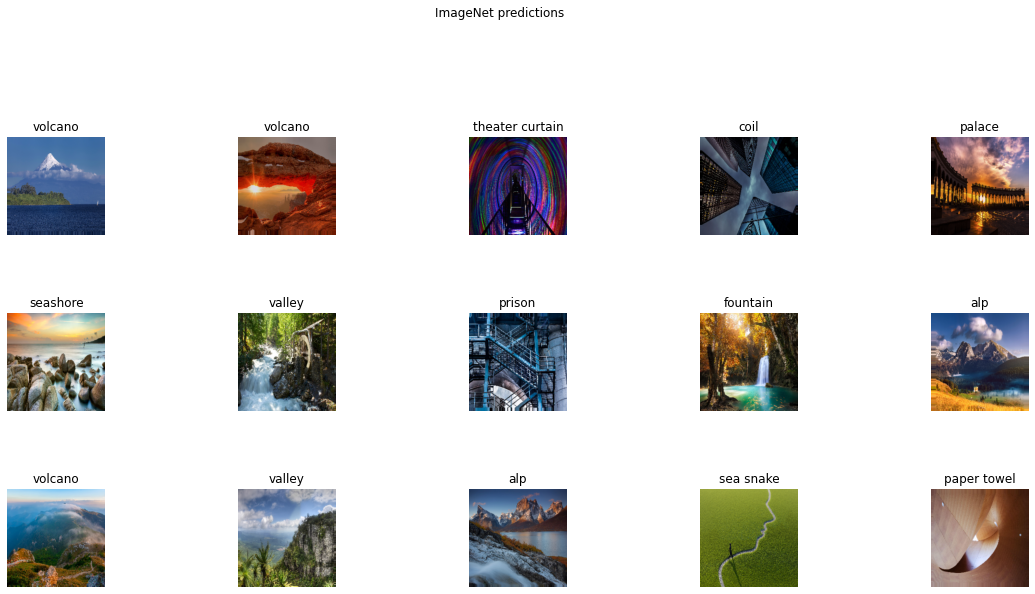

In [19]:
result_batch = classifier.predict(sample_train_images)
#result_batch.shape
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
#predicted_class_names
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_train_images[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

## First Model: playing with TF-Hub

In [20]:
classifier.trainable=False

In [27]:
model = tf.keras.Sequential([
  classifier,
  layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1001)              3540265   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1002      
Total params: 3,541,267
Trainable params: 1,002
Non-trainable params: 3,540,265
_________________________________________________________________


In [28]:
#predictions = model(sample_train_images)
#predictions.shape

In [29]:
opt = tf.keras.optimizers.Adam(
    learning_rate = 0.0007
)
model.compile(optimizer = opt,
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
             metrics=['accuracy','AUC','Precision'])

In [30]:
history = model.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = 10,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)#,
    #batch_stats_callback = CollectBatchStats()
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 15 steps, validate for 2 steps
Epoch 1/10
15/15 [==============================] - 25s 2s/step - loss: 0.9194 - accuracy: 0.5068 - AUC: 0.4686 - Precision: 0.4100 - val_loss: 0.6729 - val_accuracy: 0.6667 - val_AUC: 0.7081 - val_Precision: 0.5455
Epoch 2/10
15/15 [==============================] - 21s 1s/step - loss: 0.7949 - accuracy: 0.5616 - AUC: 0.5790 - Precision: 0.4700 - val_loss: 0.5701 - val_accuracy: 0.7333 - val_AUC: 0.7871 - val_Precision: 0.6154
Epoch 3/10
15/15 [==============================] - 20s 1s/step - loss: 0.6468 - accuracy: 0.6256 - AUC: 0.6832 - Precision: 0.5385 - val_loss: 0.5837 - val_accuracy: 0.7000 - val_AUC: 0.7608 - val_Precision: 0.5833
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 0.6139 - accuracy: 0.6347 - AUC: 0.7046 - Precision: 0.5488 - val_loss: 0.4687 - val_accuracy: 0.7667 - val_AUC: 0.8660 - val_Precision: 0.7500
Epoch 5/10
15/15 [==============================] - 22s 1s/step - loss: 0.5672 - accuracy: 0.72

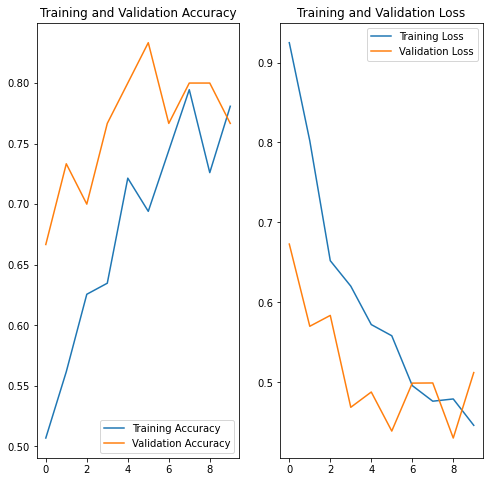

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

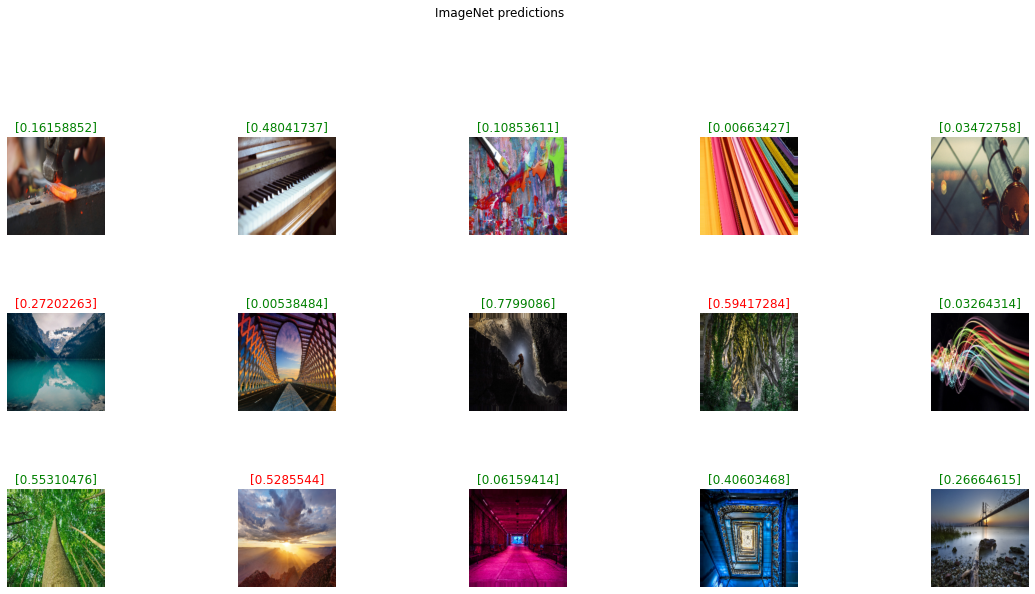

In [35]:
THRESHOLD = 0.5

sample_val_images, sample_label_images = next(val_data_gen)
result_batch = model.predict(sample_val_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_val_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

# Model no.2: extract features and apply transfer learning

In [36]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

In [37]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3),
                                        trainable=False)

In [44]:
model_2 = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(1,activation = 'sigmoid')
])

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
opt = tf.keras.optimizers.Adam(
    learning_rate = 0.001
)
model_2.compile(optimizer = opt,
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
             metrics=['accuracy','AUC'])

In [46]:
history = model_2.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = 10,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)#,
    #batch_stats_callback = CollectBatchStats()
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 15 steps, validate for 2 steps
Epoch 1/10
15/15 [==============================] - 22s 1s/step - loss: 0.8474 - accuracy: 0.4475 - AUC: 0.4135 - val_loss: 0.7489 - val_accuracy: 0.5333 - val_AUC: 0.5057
Epoch 2/10
15/15 [==============================] - 21s 1s/step - loss: 0.6719 - accuracy: 0.6027 - AUC: 0.6178 - val_loss: 0.5750 - val_accuracy: 0.7333 - val_AUC: 0.6790
Epoch 3/10
15/15 [==============================] - 18s 1s/step - loss: 0.5934 - accuracy: 0.6758 - AUC: 0.7205 - val_loss: 0.6518 - val_accuracy: 0.6667 - val_AUC: 0.6335
Epoch 4/10
15/15 [==============================] - 18s 1s/step - loss: 0.5700 - accuracy: 0.6575 - AUC: 0.7564 - val_loss: 0.6428 - val_accuracy: 0.6667 - val_AUC: 0.6307
Epoch 5/10
15/15 [==============================] - 18s 1s/step - loss: 0.5455 - accuracy: 0.6895 - AUC: 0.7742 - val_loss: 0.5632 - val_accuracy: 0.6333 - val_AUC: 0.7017
Epoch 6/10
15/15 [==============================] - 17s 1s/step - loss: 0.5026 - accuracy: 0.7352 -

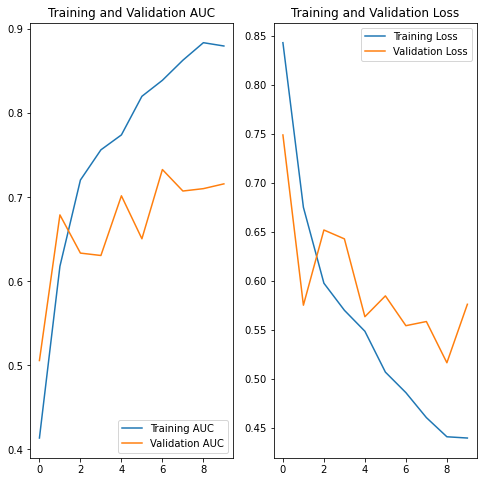

In [49]:
acc = history.history['AUC']
val_acc = history.history['val_AUC']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC')
plt.plot(epochs_range, val_acc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

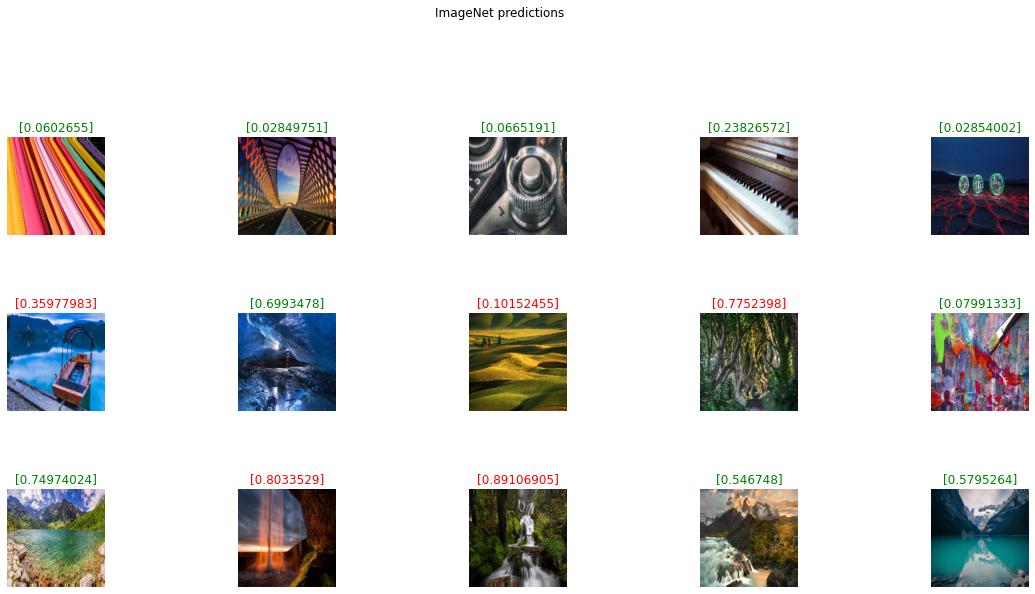

In [51]:
THRESHOLD = 0.5

sample_val_images, sample_label_images = next(val_data_gen)
result_batch = model_2.predict(sample_val_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_val_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [56]:
#Saved Chosen Model
tf.saved_model.save(model_2,"../checkpoints/saved_model")

INFO:tensorflow:Assets written to: ../checkpoints/saved_model\assets


INFO:tensorflow:Assets written to: ../checkpoints/saved_model\assets


In [66]:
#Check Load method
new_model = tf.keras.models.load_model("../checkpoints/saved_model")

# Check its architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [67]:
from random import choice
file  = choice([f for f in os.listdir(train_good_dir)])
im = Image.open(os.path.join(train_good_dir, file)).resize(IMAGE_SHAPE)
#im
im = np.array(im)/255.0
#im.shape
result = model_2.predict(im[np.newaxis, ...])
result.shape
#plt.imshow(im)
#plt.axis('off')
#predicted_class_name = imagenet_labels[predicted_class]
#_ = plt.title("Prediction: " + predicted_class_name.title())

(1, 1)

## Model 3: add dropout

In [69]:
handle_base = "mobilenet_v2_100_224"

import os

os.environ["TFHUB_CACHE_DIR"] = "/tmp/model"


MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SHAPE))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [77]:
do_fine_tuning = False 

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1,
                          activation = 'sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)
                         )
])
model.build((None,)+IMAGE_SHAPE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [78]:
model.compile(
  optimizer='adam' ,
    #tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
  metrics=['accuracy','AUC'])

In [79]:
history = model.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = 10,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 15 steps, validate for 2 steps
Epoch 1/10
15/15 [==============================] - 26s 2s/step - loss: 0.7948 - accuracy: 0.4840 - AUC: 0.5171 - val_loss: 0.7394 - val_accuracy: 0.5333 - val_AUC: 0.4450
Epoch 2/10
15/15 [==============================] - 28s 2s/step - loss: 0.6970 - accuracy: 0.5822 - AUC: 0.6158 - val_loss: 0.6851 - val_accuracy: 0.5667 - val_AUC: 0.5694
Epoch 3/10
15/15 [==============================] - 25s 2s/step - loss: 0.6165 - accuracy: 0.6438 - AUC: 0.6994 - val_loss: 0.6711 - val_accuracy: 0.5667 - val_AUC: 0.6148
Epoch 4/10
15/15 [==============================] - 19s 1s/step - loss: 0.5877 - accuracy: 0.6849 - AUC: 0.7259 - val_loss: 0.6058 - val_accuracy: 0.6000 - val_AUC: 0.6890
Epoch 5/10
15/15 [==============================] - 22s 1s/step - loss: 0.5515 - accuracy: 0.6849 - AUC: 0.7694 - val_loss: 0.6204 - val_accuracy: 0.6000 - val_AUC: 0.6794
Epoch 6/10
15/15 [==============================] - 30s 2s/step - loss: 0.5554 - accuracy: 0.6758 -

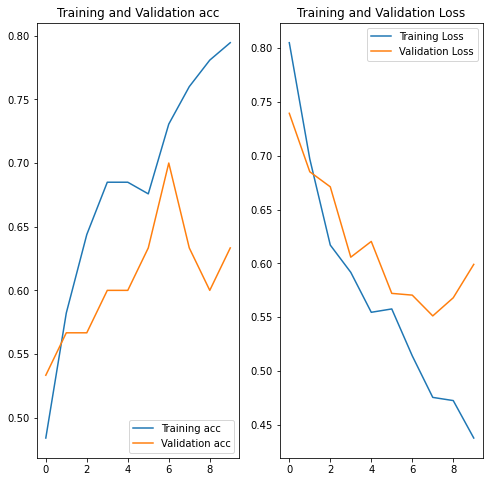

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training acc')
plt.plot(epochs_range, val_acc, label='Validation acc')
plt.legend(loc='lower right')
plt.title('Training and Validation acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

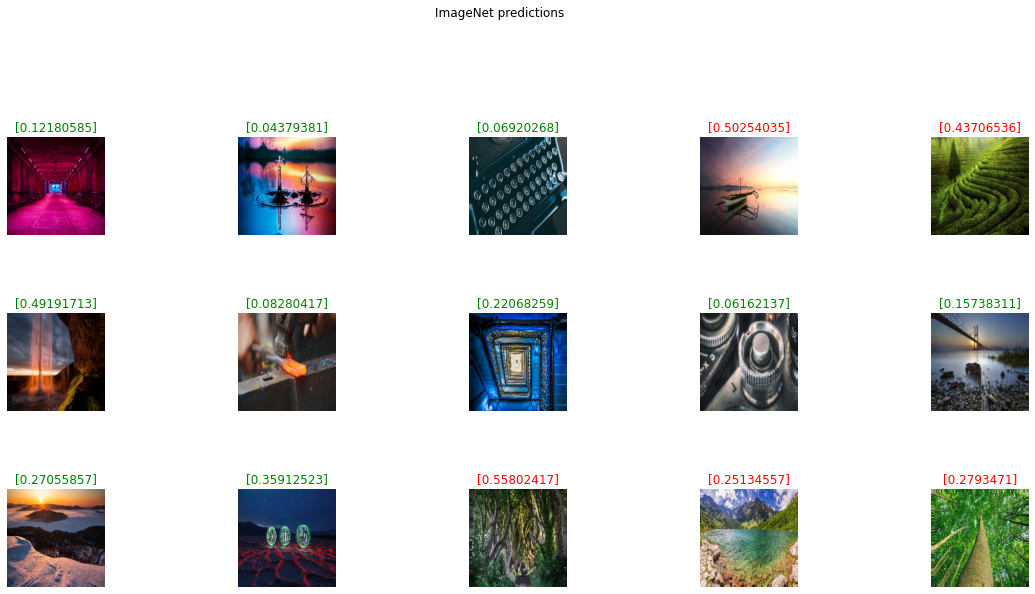

In [84]:
THRESHOLD = 0.5

sample_val_images, sample_label_images = next(val_data_gen)
result_batch = model.predict(sample_val_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_val_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

# Save just a model...

In [85]:
#Saved Chosen Model
tf.saved_model.save(model,"../checkpoints/saved_model")

INFO:tensorflow:Assets written to: ../checkpoints/saved_model\assets


INFO:tensorflow:Assets written to: ../checkpoints/saved_model\assets
